# An Analysis of Winning Factors in The International 2017 Tournament: DotA 2

## By Zhe Lu (zl1033)

### A Brief Introduction to DotA 2

DotA 2 (Defense of The Ancients) is a massive multiplayer online battle arena game ([MOBA](https://en.wikipedia.org/wiki/Multiplayer_online_battle_arena)) developed by [Valve Corporation](https://en.wikipedia.org/wiki/Valve_Corporation). Two opposing teams (Radiant and Dire) each select 5 heroes out of a 115-hero pool and battle until one team's Ancient Building is down. 

### The International 2017

The annual tournament takes place in August in Seattle Key Arena and it gathers 18 most talented teams around the world. The prize pool for the 2017 tournament was a whopping [25 million dollars](http://www.espn.com/esports/story/_/id/20267648/the-international-7-prize-pool-breaks-records) and the grand winner takes home nearly 11 million dollars. Undoubtedly, TI7 hosted by Valve was the most influential professional e-sport tournament ever. 

### Variables Explained

Numerous variables factor into the outcome of a game: gold, kill/death/assist ratio, pre-game hero selections, just to name a few. For this analysis, I would like to dive deeper into statistics that might appear trivial to an amateur player, but those I expect to play a fairly large role in professional games. Just like any other sports event, the smallest mistakes can translate to big losses on the scoreboard. After analyzing the data, I hope to find out if it is true in a professional DotA game. 

I chose three variables: total runes grabbed, total stun time and total observer wards planted. 
1. **Runes** appear on the map every two minutes and they give the player who grabs it a small amount of gold that could turn into better equipment. In addition, this stat may also reflect something more significant than mere gold amount, because teams tend to compete hard on runes, and a dominanace on the stat might reflect the overall advantage the team has throughout the game;
2. **Total stun time** reflects one team's ability to stun enemy heroes and attack them. It is arguably one of the most crucial components in a team fight, since most heroes paired with professional capabilities are pretty evasive;
3. **Total observer wards planted** reflect a team's control of the map as they give visibility to areas on the map that would otherwise be dark. This stat is particularly important as more control over the map will very likely lead to higher team economy. 

### Setup

Data came from here: https://www.opendota.com/explorer

In [39]:
SQL="""
SELECT t1.id, 
       t1.radiant_win, 
       t1.duration, 
       t1.radiant_obs, 
       t2.dire_obs, 
       t1.radiant_runes_pickup, 
       t2.dire_runes_pickup, 
       t1.radiant_stuns, 
       t2.dire_stuns 
FROM   (SELECT m.match_id           AS id, 
               m.radiant_win, 
               m.duration, 
               Sum(pm.obs_placed)   AS radiant_obs, 
               Sum(pm.rune_pickups) AS radiant_runes_pickup, 
               Sum(pm.stuns)        AS radiant_stuns 
        FROM   matches AS m, 
               player_matches AS pm 
        WHERE  m.leagueid = 5401 
               AND pm.match_id = m.match_id 
               AND player_slot < 5 
        GROUP  BY id) AS t1 
       LEFT JOIN (SELECT m.match_id           AS id, 
                         Sum(pm.obs_placed)   AS dire_obs, 
                         Sum(pm.rune_pickups) AS dire_runes_pickup, 
                         Sum(pm.stuns)        AS dire_stuns 
                  FROM   matches AS m, 
                         player_matches AS pm 
                  WHERE  m.leagueid = 5401 
                         AND pm.match_id = m.match_id 
                         AND player_slot > 127 
                  GROUP  BY id) AS t2 
              ON t1.id = t2.id 
ORDER  BY id DESC
"""

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import datetime as dt
df = pd.read_csv('data.csv', header=0).dropna()   
# Load data from csv 

In [41]:
print('Last Updated', dt.date.today())

Last Updated 2017-12-21


In [42]:
df.columns
# Preview dataframe headers

Index(['id', 'radiant_win', 'duration', 'radiant_obs', 'dire_obs',
       'radiant_runes_pickup', 'dire_runes_pickup', 'radiant_stuns',
       'dire_stuns'],
      dtype='object')

In [43]:
df.head(5)
# Preview the top 5 sets of data

,id,radiant_win,duration,radiant_obs,dire_obs,radiant_runes_pickup,dire_runes_pickup,radiant_stuns,dire_stuns
0,3372726385,False,2719,18.0,20.0,49.0,55.0,194.6930,82.1098
1,3372676225,True,2051,15.0,14.0,35.0,45.0,85.3829,51.2215
2,3372622939,False,1654,11.0,12.0,23.0,34.0,123.3330,28.2836
3,3372455628,True,2931,21.0,20.0,73.0,33.0,183.2160,263.4450
4,3372386596,True,1880,13.0,14.0,44.0,20.0,119.3300,22.5222


In [44]:
df.shape
# Total of 538 games played in the tournament

(538, 9)

### Data Manipulation

In [45]:
def ratio_helper(row, postfix):
    attr = "%s_%s"
    winner, loser = "dire", "radiant" 
    if row['radiant_win']:
        winner = "radiant"
        loser = "dire"
    return row[attr % (winner, postfix)] / row[attr % (loser, postfix)]
df['rRunes'] = df.apply(lambda x: ratio_helper(x, 'runes_pickup'), axis=1)
df['rObs'] = df.apply(lambda x: ratio_helper(x, 'obs'), axis=1)
df['rStuns'] = df.apply(lambda x: ratio_helper(x, 'stuns'), axis=1)
# Data Manipulation
# Adding three ratios of 'winner's data / loser's data'

### Runes 

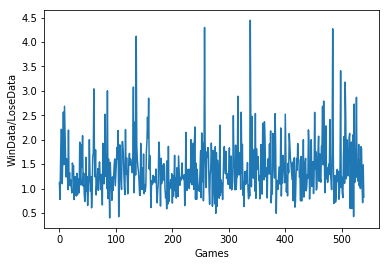

In [46]:
plt.plot(df['rRunes'])
plt.xlabel('Games')
plt.ylabel('WinData/LoseData')
plt.show()
# Runes Analysis

In [47]:
df['rRunes'].describe()

count    538.000000
mean       1.395819
std        0.551136
min        0.399061
25%        1.028612
50%        1.278233
75%        1.639091
max        4.444444
Name: rRunes, dtype: float64

As described above, in at least 75% of the games, the winning side grabbed more runes than the losing team, and winners on average grabbed 1.4 times more runes. What caught me by surprise was the minimum ratio was only 0.40. My first guess would be that particular game was a classic "comeback" game in which the losing team dominated during most of the times and the other team caught a rare chance to flip the table and won the game only in the very late stage of the game. 

### Observer Wards

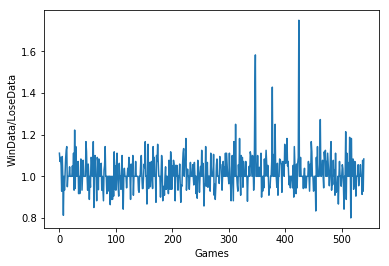

In [48]:
plt.plot(df['rObs'])
plt.xlabel('Games')
plt.ylabel('WinData/LoseData')
plt.show()

In [49]:
df['rObs'].describe()

count    538.000000
mean       1.016714
std        0.084595
min        0.800000
25%        1.000000
50%        1.000000
75%        1.062500
max        1.750000
Name: rObs, dtype: float64

It is unsurprising to see such even distribution of observer wards planted by either team in competitive games. Winning teams would very much like to retain their advantages by aggressively controlling the map. On the other hand, losing teams would wish to find some breathing room as well. 

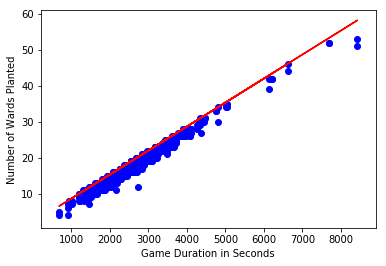

In [50]:
plt.scatter(df['duration'], df['radiant_obs'], color='blue')
plt.scatter(df['duration'], df['dire_obs'], color='blue')
plt.plot(df['duration'], df['duration']/150 + 2, color='red')
plt.xlabel('Game Duration in Seconds')
plt.ylabel('Number of Wards Planted')
plt.show()

I should explain: an observer ward lasts 360 seconds on the map and costs 80 gold. This graph shows tha pro teams habitually buy and place wards whenever possible throughout the whole game, which is absent in amateur games since buying wards puts extra pressure on support players. 

### Stun Time

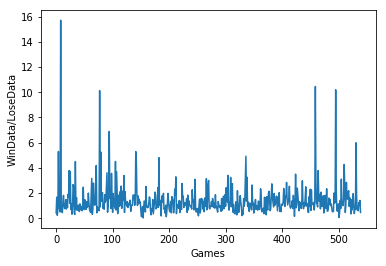

In [51]:
plt.plot(df['rStuns'])
plt.xlabel('Games')
plt.ylabel('WinData/LoseData')
plt.show()

In [52]:
df['rStuns'].describe()


count    538.000000
mean       1.388458
std        1.277561
min        0.020916
25%        0.760348
50%        1.097467
75%        1.601766
max       15.723383
Name: rStuns, dtype: float64

Despite common belief, a team doesn't need overwhelming stun power to win a game. Team fighting is extremely important in a DotA game, but data prove that in most games, stun advantages by winning teams were trivial (mean 1.39). It is because avoiding team fight was a prevailing strategy among pro teams at the time of the tournament. 

### Prediction Based on Variables

Since the dependent variable in this experiment is dichotomous (either win or lose), it would be quite inaccurate to use it as a quantitative variable to produce a regression analysis. As an alternative, I tried to determine the accuracy of predicting the outcome of a game given the three independent variables. Following is the setup. 

In [53]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
# machine learning tool in python.

In [54]:
df = pd.read_csv('data.csv', header=0).dropna()
df['rdRunes'] = df.apply(lambda x: ratio_rd(x, 'runes_pickup'), axis=1)
df['rdObs'] = df.apply(lambda x: ratio_rd(x, 'obs'), axis=1)
df['rdStuns'] = df.apply(lambda x: ratio_rd(x, 'stuns'), axis=1)
df.columns[-3:]

Index(['rdRunes', 'rdObs', 'rdStuns'], dtype='object')

In [55]:
def ratio_rd(row, postfix):
        attr = "%s_%s"
        return row[attr % ('radiant', postfix)] / row[attr % ('dire', postfix)]

In [56]:
def svm_helper(df, trainingPercentage=0.6):
# Slicing for training and testing
# Shuffle the array
        threshold = int(df.shape[0] * trainingPercentage)
        training_df = df.iloc[:threshold]
        testing_df = df.iloc[threshold:]
        clf = SVC(decision_function_shape='ovo', kernel='linear')
        clf.fit(training_df.iloc[:, -3:], training_df['radiant_win'])
        testing_df['predict'] = clf.predict(testing_df.iloc[:, -3:])
        result = np.sum(testing_df['predict'] == testing_df['radiant_win'])
        print("Model Accuracy: {:.2%}".format(result / testing_df.shape[0]))
        weights = clf.coef_[0]
        print("Weights for runes_pickup: {}".format(weights[0]))
        print("Weights for obs_placed  : {}".format(weights[1]))
        print("Weights for stuns       : {}".format(weights[2]))
for i in range(3):
        df = shuffle(df)
        print('Trial 1')
        svm_helper(df)

Trial 1
Model Accuracy: 76.85%
Weights for runes_pickup: 3.3363147723522264
Weights for obs_placed  : 1.4719320368898838
Weights for stuns       : 0.18456713478669995
Trial 1
Model Accuracy: 76.39%
Weights for runes_pickup: 3.536720323568371
Weights for obs_placed  : 1.3467893569074083
Weights for stuns       : 0.2617707074983997
Trial 1
Model Accuracy: 79.63%
Weights for runes_pickup: 3.0590840182860957
Weights for obs_placed  : 1.8841684683702238
Weights for stuns       : 0.008760956810276221


/Users/deoxymoron/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Based on the trials, the model is quite accurate for a sample size of about 540 games. Since the variables are ex post facto, the results are more for a training purpose rather than an actual prediction of the game. Possible use of such data could be something on the line of "don't let your opponent pick up ... more runes than you do or you will very likely be at a disadvantage." 

Of course, everything produced from this entire model would be much more accurate if we repeat the procedure on a larger sample (5,400 games maybe?), but the trends displayed here could be useful for team coaches and game analysts if they are willing to extrapolate. 

### Finally...

As machine learning continues to heat up in every aspect of our life, I have to mention [OpenAI](https://blog.openai.com/dota-2/) at the end of my project because it is simply amazing. Google's AlphaGo had managed to beat the best human Go player in the past, and in August, the cutting-edge OpenAI successfully defeated the best DotA 2 players one-on-one in exhibit matches. This is particularly telling of the gaming community that has already been employing heavy capabilities of deep learning technologies. From designing the game to beating it, what can't machines do?